In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('/Users/pchaberski/projects/image-embeddings')

In [3]:
import torch
from data.hm_data import HMDataset
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import pandas as pd

In [4]:
from utils.configuration import load_config
# from utils.logger import configure_logger
import neptune.new as neptune
import os
from model.autoencoder_module import LitHMAutoEncoder
import pytorch_lightning as pl
from importlib import import_module

In [5]:
cfg = load_config('config.yml')

---

Test data class

In [6]:
data_train_scaled = HMDataset(
    data_path=os.path.join(cfg.get('data_path'), 'train'),
    center=False,
    center_params=cfg.get('center_params')
)

data_train_centered = HMDataset(
    data_path=os.path.join(cfg.get('data_path'), 'train'),
    center=True,
    center_params=cfg.get('center_params')
)

In [7]:
idx = 666

tens_scaled = data_train_scaled[idx]
tens_centered = data_train_centered[idx]

print('Original, scaled 0-1:')
print(torch.min(tens_scaled), torch.max(tens_scaled))
print('Center:')
print(torch.min(tens_centered), torch.max(tens_centered))

Original, scaled 0-1:
tensor(0.1765) tensor(0.9373)
Center:
tensor(-2.9413) tensor(0.8531)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


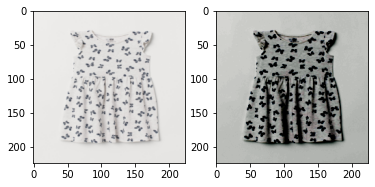

In [8]:
_, axarr = plt.subplots(1, 2)
axarr[0].imshow(tens_scaled.permute(1, 2, 0))
axarr[1].imshow(tens_centered.permute(1, 2, 0))

___

In [9]:
data_valid = HMDataset(
    data_path=os.path.join(cfg.get('data_path'), 'valid'),
    center=cfg.get('centered'),
    center_params=cfg.get('center_params')
)

In [10]:
model = LitHMAutoEncoder(
    data_path=cfg.get('data_path'),
    batch_size=cfg.get('batch_size'),
    num_workers=cfg.get('num_workers'),
    center=cfg.get('center'),
    center_params=cfg.get('center_params'),
    optimizer=getattr(import_module('torch.optim'), cfg.get('optimizer')),
    optimizer_params=cfg.get('optimizer_params'),
    encoder=getattr(import_module('model.encoders'), cfg.get('encoder'))(cfg.get('embedding_size')),
    decoder=getattr(import_module('model.decoders'), cfg.get('decoder'))(cfg.get('embedding_size')),
    # run=run
)

In [11]:
trainer = pl.Trainer(
    max_epochs=cfg.get('num_epochs'),
    gpus=cfg.get('num_gpus'),
    num_sanity_val_steps=0
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [12]:
trainer.fit(model)


  | Name    | Type        | Params
----------------------------------------
0 | encoder | EncoderBase | 19.3 M
1 | decoder | DecoderBase | 19.4 M
----------------------------------------
38.7 M    Trainable params
0         Non-trainable params
38.7 M    Total params
154.777   Total estimated model params size (MB)
/opt/miniconda3/envs/image-embeddings/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/miniconda3/envs/image-embeddings/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 whic

Epoch 1: 100%|██████████| 64/64 [00:37<00:00,  1.70it/s, loss=0.264, v_num=194]


In [13]:
iter(model.train_dataloader())

In [14]:
def imshow(img):
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.pause(1)
    plt.close()

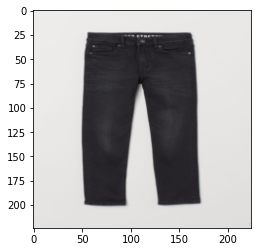

In [15]:
imshow(data_valid[0])

In [16]:
# data_iter = iter(data_module.val_dataloader())
data_iter = iter(model.val_dataloader())

In [17]:
sample_size = 16

In [18]:
sample_images = data_iter.next()[:sample_size, :, :, :]
sample_images.shape

torch.Size([16, 3, 224, 224])

In [19]:
torchvision.utils.make_grid(sample_images).shape

torch.Size([3, 454, 1810])

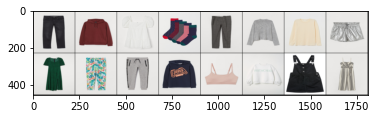

In [20]:
imshow(torchvision.utils.make_grid(sample_images))

In [21]:
model.freeze()
model.eval()
embeddings = model.encoder(sample_images.reshape(sample_size, model.image_size[0]*model.image_size[1]*3))
embeddings.shape

torch.Size([16, 32])

In [22]:
embeddings.numpy()

array([[ 0.06470372, -0.05492994, -0.15433526,  0.12523133,  0.00483722,
         0.05292141,  0.10033809, -0.08702925,  0.16195846,  0.14130467,
         0.14241321,  0.09992229, -0.09224585, -0.01431711, -0.1331957 ,
         0.04085486,  0.08181828, -0.07392505,  0.11686188,  0.01590208,
        -0.17199135, -0.1421017 , -0.15189667,  0.01728051, -0.06363562,
        -0.17335048,  0.08685208, -0.11272313,  0.10155925,  0.1884483 ,
        -0.09707531, -0.09958117],
       [ 0.06470372, -0.05492994, -0.15433526,  0.12523133,  0.00483722,
         0.05292141,  0.10033809, -0.08702925,  0.16195846,  0.14130467,
         0.14241321,  0.09992229, -0.09224585, -0.01431711, -0.1331957 ,
         0.04085486,  0.08181828, -0.07392505,  0.11686188,  0.01590208,
        -0.17199135, -0.1421017 , -0.15189667,  0.01728051, -0.06363562,
        -0.17335048,  0.08685208, -0.11272313,  0.10155925,  0.1884483 ,
        -0.09707531, -0.09958117],
       [ 0.06470372, -0.05492994, -0.15433526,  0.1252

In [23]:
pd.DataFrame(embeddings.numpy())

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.064704,-0.05493,-0.154335,0.125231,0.004837,0.052921,0.100338,-0.087029,0.161958,0.141305,...,-0.151897,0.017281,-0.063636,-0.17335,0.086852,-0.112723,0.101559,0.188448,-0.097075,-0.099581
1,0.064704,-0.05493,-0.154335,0.125231,0.004837,0.052921,0.100338,-0.087029,0.161958,0.141305,...,-0.151897,0.017281,-0.063636,-0.17335,0.086852,-0.112723,0.101559,0.188448,-0.097075,-0.099581
2,0.064704,-0.05493,-0.154335,0.125231,0.004837,0.052921,0.100338,-0.087029,0.161958,0.141305,...,-0.151897,0.017281,-0.063636,-0.17335,0.086852,-0.112723,0.101559,0.188448,-0.097075,-0.099581
3,0.064704,-0.05493,-0.154335,0.125231,0.004837,0.052921,0.100338,-0.087029,0.161958,0.141305,...,-0.151897,0.017281,-0.063636,-0.17335,0.086852,-0.112723,0.101559,0.188448,-0.097075,-0.099581
4,0.064704,-0.05493,-0.154335,0.125231,0.004837,0.052921,0.100338,-0.087029,0.161958,0.141305,...,-0.151897,0.017281,-0.063636,-0.17335,0.086852,-0.112723,0.101559,0.188448,-0.097075,-0.099581
5,0.064704,-0.05493,-0.154335,0.125231,0.004837,0.052921,0.100338,-0.087029,0.161958,0.141305,...,-0.151897,0.017281,-0.063636,-0.17335,0.086852,-0.112723,0.101559,0.188448,-0.097075,-0.099581
6,0.064704,-0.05493,-0.154335,0.125231,0.004837,0.052921,0.100338,-0.087029,0.161958,0.141305,...,-0.151897,0.017281,-0.063636,-0.17335,0.086852,-0.112723,0.101559,0.188448,-0.097075,-0.099581
7,0.064704,-0.05493,-0.154335,0.125231,0.004837,0.052921,0.100338,-0.087029,0.161958,0.141305,...,-0.151897,0.017281,-0.063636,-0.17335,0.086852,-0.112723,0.101559,0.188448,-0.097075,-0.099581
8,0.064704,-0.05493,-0.154335,0.125231,0.004837,0.052921,0.100338,-0.087029,0.161958,0.141305,...,-0.151897,0.017281,-0.063636,-0.17335,0.086852,-0.112723,0.101559,0.188448,-0.097075,-0.099581
9,0.064704,-0.05493,-0.154335,0.125231,0.004837,0.052921,0.100338,-0.087029,0.161958,0.141305,...,-0.151897,0.017281,-0.063636,-0.17335,0.086852,-0.112723,0.101559,0.188448,-0.097075,-0.099581


In [24]:
decoded_sample_images = model.decoder(embeddings).reshape(sample_size, 3, model.image_size[0], model.image_size[1])
decoded_sample_images.shape

torch.Size([16, 3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


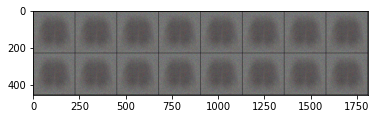

In [25]:
imshow(torchvision.utils.make_grid(decoded_sample_images))